MODS Phenotypes: Step 6. Phenotype Analysis
===

In [1]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import multiprocessing
import dill as pickle

n_cpus = multiprocessing.cpu_count()

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="notebook")

In [3]:
from collections import ChainMap

In [4]:
import seaborn as sns
import matplotlib

In [5]:
sys.path.insert(0, "/opt/bmi-585r/KLAB_SAIL/MODSPhenotypes/gSpan")
import shlex
from src.gspan_mining.main import parse_args, main
from src.gspan_mining.data_processing import process_graph_data

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

---

# Phenotyping

In [7]:
phenotype_df = pd.read_parquet('/home/gmatlin/tmp/phenotype_df_12112022.parquet')

# TODO: remove patients who did not have 2+ organ failures

## remove all patients with no phenotypes discovered

In [9]:
no_phenotype_index = phenotype_df[(phenotype_df.T.sum(axis=0)==0)].index

In [10]:
phenotype_df.drop(no_phenotype_index, inplace=True)

## assign all patients to phenotype
patients are assigned based on the phenotype with the highest probability in *sanchez-pinto 2019*

In [11]:
patient_phenotypes = phenotype_df.idxmax(axis=1)
phenotype_counts = patient_phenotypes.value_counts().reset_index()
phenotype_counts.columns = ['phenotype','count']

In [12]:
phenotype_names = {'phenotype_0': '\u03B1',
'phenotype_1': '\u03B2',
'phenotype_2': '\u03B3',
'phenotype_3': '\u03B4',
'phenotype_4': '\u03B5'}

In [13]:
phenotype_counts['phenotype'] = phenotype_counts['phenotype'].map(phenotype_names)

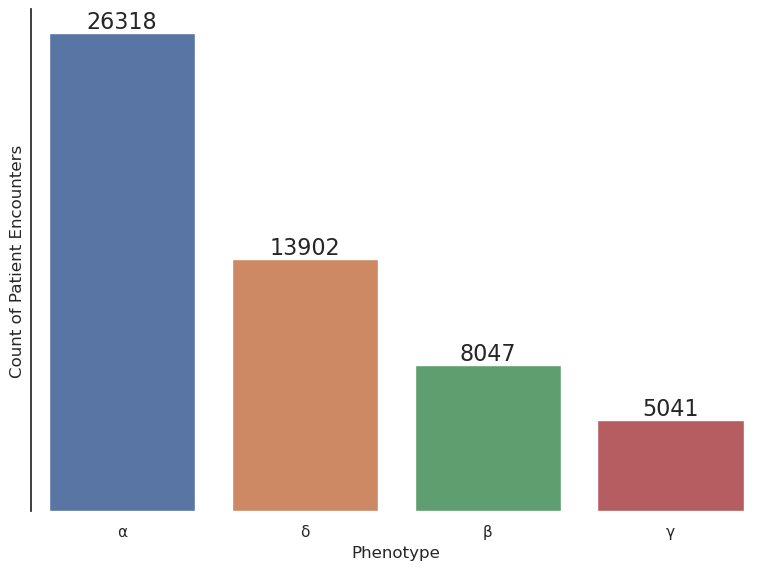

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(data=phenotype_counts, x="phenotype", y="count")
sns.despine(bottom=True)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Phenotype')
ax.set_ylabel('Count of Patient Encounters')
plt.setp(fig.axes, yticks=[])
plt.tight_layout(h_pad=2)

In [20]:
patient_phenotypes

,Unnamed: 0,0
0,46661764186,phenotype_0
1,12989950338,phenotype_3
2,62471000307,phenotype_0
3,3419660022,phenotype_0
4,31967637101,phenotype_0
...,...,...
53303,20447148142,phenotype_0
53304,7677654159,phenotype_3
53305,48502160311,phenotype_3
53306,7361767076,phenotype_0


In [18]:
patient_phenotypes.to_csv('/opt/bmi-585r/KLAB_SAIL/patient_phenotypes_20221209.csv')

In [19]:
patient_phenotypes = pd.read_csv('/opt/bmi-585r/KLAB_SAIL/patient_phenotypes_20221209.csv')

# plotting the frequent subgraphs

## get the subgraph representations

In [124]:
organs = {'SOFA_coag_score': 'Coagulation',
 'SOFA_renal_score': 'Renal',
 'SOFA_hep_score': 'Hepatic',
 'SOFA_neuro_score': 'Neurological',
 'SOFA_cardio_score': 'Cardiovascular',
 'SOFA_resp_score': 'Respiratory'}

In [125]:
organ_scores = [fp.name.replace('.gSpan','') for fp in graph_miner.gspan_fps]

In [126]:
organ_map = {k:organs[v] for k,v in zip(list(range(len(organ_scores))), organ_scores)}

In [127]:
organ_map

{0: 'Coagulation',
 1: 'Renal',
 2: 'Hepatic',
 3: 'Neurological',
 4: 'Cardiovascular',
 5: 'Respiratory'}

In [128]:
gspan_subgraphs = graph_miner.gspan_subgraphs

In [129]:
subgraphs =  dict(ChainMap(*[gspan_subgraphs[i] for i in range(len(gspan_subgraphs))]))

In [130]:
nnm_df.sum()

46661764186    12.0
12989950338     3.0
62471000307     3.0
3419660022     21.0
31967637101     3.0
               ... 
7361767076      3.0
9990544239      4.0
19229510276     0.0
65806030119     0.0
46244270093     0.0
Length: 75977, dtype: float64

In [131]:
def get_subgraph_count(nnm_df:pd.DataFrame, patient_phenotypes: pd.DataFrame, phenotype: str):
    phenotype_encounters = patient_phenotypes[patient_phenotypes == phenotype].index
    phenotype_count = len(phenotype_encounters)
    phenotype_subgraph_count = nnm_df.loc[:,list(phenotype_encounters)].sum(axis=1).sort_values(ascending=False)
    return phenotype_subgraph_count

def get_top10_subgraphs(phenotype_top10:pd.DataFrame):
    phenotype_top10 = [(x,subgraphs[x]) for x in list(phenotype_subgraph_count[:10].index)]
    return phenotype_top10

def plot_top10_subgraphs(phenotype_subgraph_count:pd.DataFrame, phenotype_top10:pd.DataFrame, total:int):
    facet_df = []
    for (n, g) in phenotype_top10:
        _df = pd.DataFrame([j.split('~') for j in g.split('->')])
        _df.columns = ['Time', 'Score']
        _df['Subgraph'] = n
        facet_df.append(_df)
    facet_df = pd.concat(facet_df)
    facet_df[['Organ','Subgraph']] = facet_df['Subgraph'].str.split('_subgraph_').tolist()
    facet_df = facet_df.astype(int)
    # facet_df['Hour'] = facet_df['Hour']+1
    facet_df['Organ'] = facet_df['Organ'].map(organ_map)

    facet_df['Time']=facet_df['Time']+1
    percents = phenotype_subgraph_count[:10].values / total
    
    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(facet_df, col="Subgraph", hue="Organ", col_wrap=5, height=1.5, sharex=False, margin_titles=True)

    # Draw a horizontal line to show the starting point
    grid.refline(y=2, linestyle=":")

    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, "Time", "Score", marker="o")

    # Adjust the tick positions and labels
    grid.set(yticks=range(5), xlim=(1,6.1), ylim=(-1, 5))

    grid.fig.set_size_inches(16,8)
    # Adjust the arrangement of the plots
    grid.fig.suptitle(f"Top 10 Common Subgraphs for Phenotype")
    grid.add_legend(bbox_to_anchor=(1, 0.25), loc='upper left', borderaxespad=0)
    grid.fig.tight_layout(w_pad=1)
    # grid.map(percents)
    return grid, percents

[0.06130803 0.0449873  0.04310515 0.04173631 0.04032799 0.03761665
 0.01626808 0.0159522  0.01550469 0.01547837]


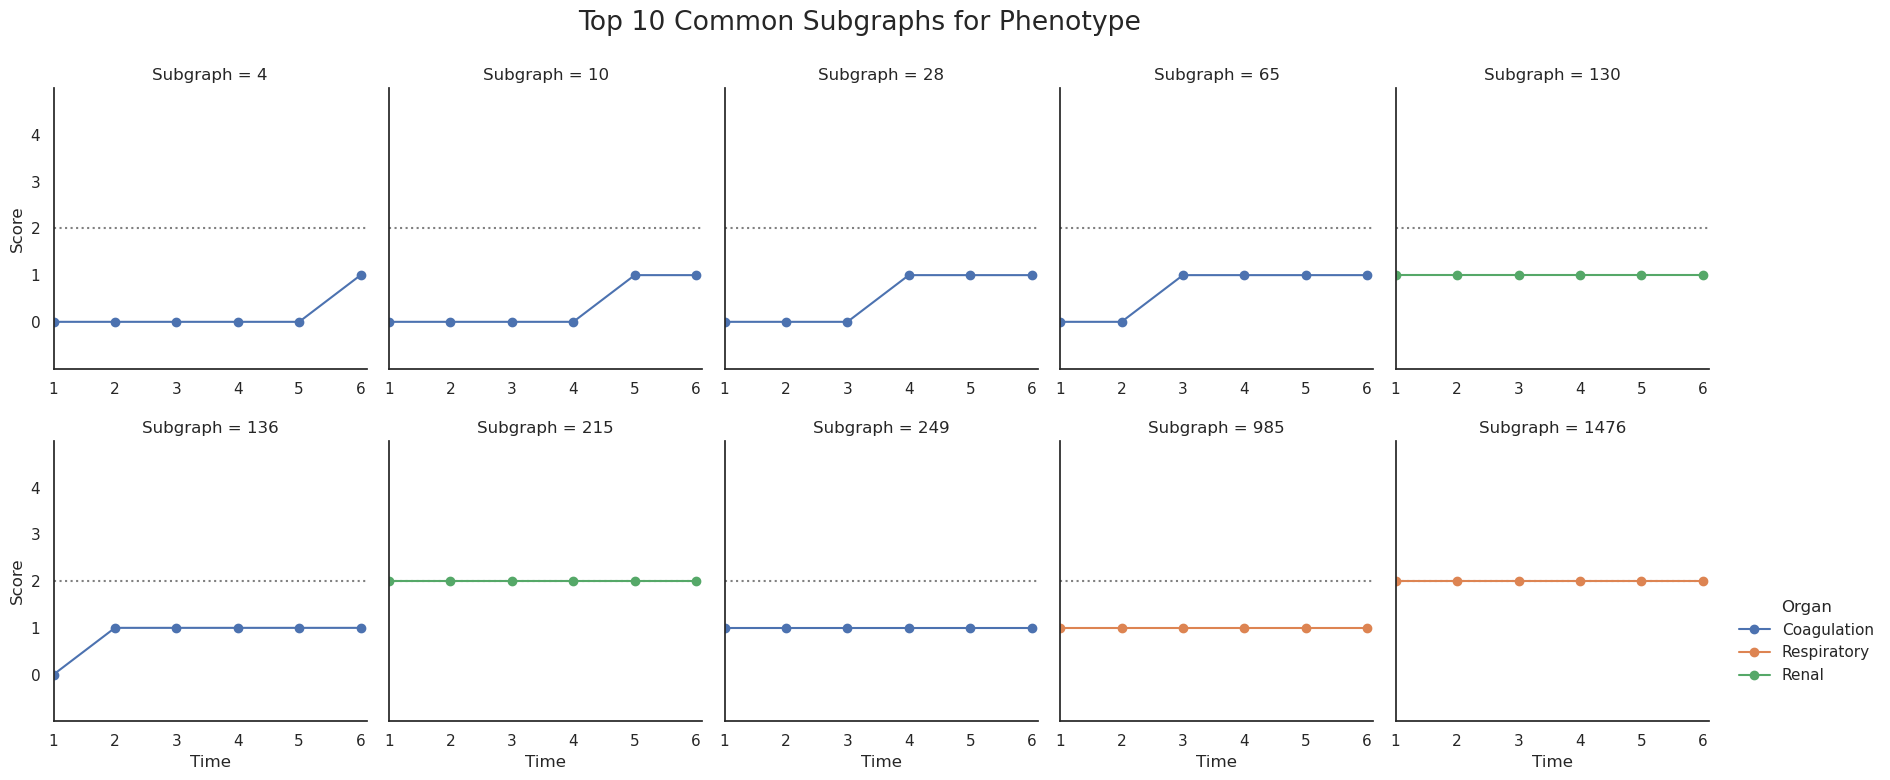

In [134]:
phenotype_subgraph_count = get_subgraph_count(nnm_df, patient_phenotypes, 'phenotype_2')
top10_subgraphs = get_top10_subgraphs(phenotype_subgraph_count)
grid, percents = plot_top10_subgraphs(phenotype_subgraph_count, top10_subgraphs, len(nnm_df.columns))
print(percents)